In [11]:
import tensorflow as tf
from dataset_helper import *
from custom_estimator import *
from modules import *
from data_utils import *
from best_exporter import *
import pickle
import matplotlib.pyplot as plt

def main(unused_args):

    input = "train.tfrecords"
    valfile = "val.tfrecords"
    testfile = "train.tfrecords"
    datadir = '/home/dataj/data/vertf/ICDAR2003_sample'
    run_type = 'test'
    ckpt_path = '/home/dataj/best/experiments/SynthAllJun5_exporter/best/model.ckpt-70373'
    parallel_cpu = 1
    tf_format = "JPG"

    trainFile = os.path.join(datadir, input)
    valFile = os.path.join(datadir, valfile)
    testFile = os.path.join(datadir, testfile)
    val_test_batch_size = 1

    batch_size = 1
    lr = 0.1
    lr_decay_steps = 1000
    lr_decay_rate = 0.99
    val_test_batch_size = 1
    train_steps = 40000
    eval_steps = 5
    eval_throttle_secs = 600
                

    model_dir = '/home/dataj/best/'

    classifier = tf.estimator.Estimator(
        model_fn=crnn_model,
        params={
            #'feature_columns': my_feature_columns,
            'hidden_size': 256,
            'batch_size': batch_size,
            'lr': lr,
            'lr_decay_steps': lr_decay_steps,
            'lr_decay_rate': lr_decay_rate,
            'test_batch_size': val_test_batch_size,
        },
        model_dir = model_dir)

    train_spec = tf.estimator.TrainSpec(
        input_fn=lambda:input_fn(trainFile, train=True, batch_size=batch_size, parallel_calls=parallel_cpu,
                                 tf_format=tf_format),
        max_steps=train_steps)

    my_feature_columns = get_feature_columns()
    serving_feature_spec = tf.feature_column.make_parse_example_spec(my_feature_columns)
    serving_input_receiver_fn = (
        tf.estimator.export.build_parsing_serving_input_receiver_fn(
            serving_feature_spec))
    exporter = BestExporter(
        name="best_exporter",
        event_file_pattern='eval_text-eval/*.tfevents.*', # must match name in eval_spec
        serving_input_receiver_fn=serving_input_receiver_fn,
        #serving_input_receiver_fn=serving_input_fn,
        exports_to_keep=5)

    eval_spec = tf.estimator.EvalSpec(
        #input_fn=lambda:input_fn(valFile, train=False, batch_size=val_test_batch_size, parallel_calls=parallel_cpu,
        #                         tf_format=tf_format),
        input_fn=lambda: input_fn(valFile, train=True, batch_size=val_test_batch_size, parallel_calls=parallel_cpu,
                                 tf_format=tf_format),
        steps=eval_steps,
        exporters=exporter,
        name='text-eval',
        throttle_secs=eval_throttle_secs)

    if run_type == 'train_and_eval':
        tf.estimator.train_and_evaluate(classifier, train_spec, eval_spec)
    elif run_type == 'eval_only':
        if ckpt_path is None:
            print ('Checkpoint path --ckpt_path required.')
            return
        eval_result = classifier.evaluate(input_fn=lambda: input_fn(valFile, train=False,
                                            batch_size=val_test_batch_size, parallel_calls=parallel_cpu,
                                            tf_format=tf_format),
                                            checkpoint_path=ckpt_path)
        #print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result['accuracy']))

    elif run_type == 'test':
        if ckpt_path is None:
            print ('Checkpoint path --ckpt_path required.')
            return
        preds = []
        test_batch_size = 1
        for result in classifier.predict(input_fn= lambda: input_fn(testFile, train=False, batch_size=test_batch_size,
                                            parallel_calls=parallel_cpu,
                                            tf_format='JPG'),
                                        checkpoint_path = ckpt_path):
            pred = ''.join([idx2char(c) for c in result['predicted_label']])
            preds.append(pred)
            #print(pred)
            #print (len(preds))
        with open('predictions', 'wb') as fp:
            pickle.dump(preds, fp)


        image_batch, label_batch = input_fn(testFile, train=False, batch_size=test_batch_size, buffer_size=2048,
                                            parallel_calls=parallel_cpu, tf_format='JPG')

        with tf.Session() as sess:
            init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
            sess.run(init_op)
            count = 0
            while True:
                try:

                    images, labels = sess.run([image_batch, label_batch])
                    dense_label = sess.run(
                        tf.sparse_to_dense(labels.indices, labels.dense_shape, labels.values, default_value=-1))
                    #print("DENSE LABEL", dense_label)
                    for i in range(test_batch_size):
                        image_i = images['image'][i]
                        #print("DENSE LABEL i", dense_label[i])
                        label = [idx2char(c) for c in dense_label[i]]
                        #print("***Label", label)
                        label = ''.join(label)
                        print('Ground truth: ', label)
                        image_i = image_i.astype(np.uint8)
                        print("image shape", image_i.shape)
                        count += 1
                        print(count)
                        plt.imshow(image_i)
                        plt.title(label)
                        plt.show()
                except tf.errors.OutOfRangeError:
                    break


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/home/dataj/best/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2735aa5390>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INPUTS SHAPE (1, 32, 100, 3)

-------------------------------
conv6: (1, 1, 24, 512)
-------------------------------

-------------------------------
map2seq inputs: (1, 1, 24, 512)
-------------------------------

-------------------------------
map2seq output: (1, 24, 512)
-------------------------------

-------------------------------
RNN output: (1, 24, 53)
-------------------------------

----------------------

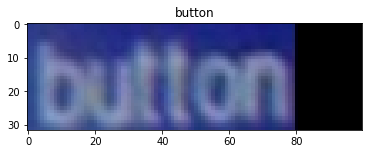

Ground truth:  GUIDELINE
image shape (32, 100, 3)
2


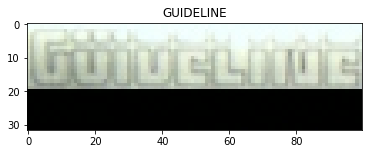

Ground truth:  MAXIMUM
image shape (32, 100, 3)
3


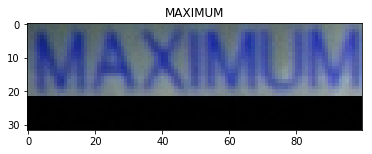

Ground truth:  Lucas
image shape (32, 100, 3)
4


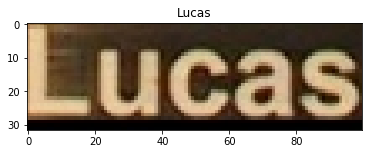

Ground truth:  COLCHESTER
image shape (32, 100, 3)
5


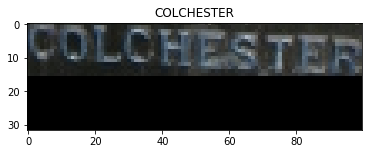

Ground truth:  MONET
image shape (32, 100, 3)
6


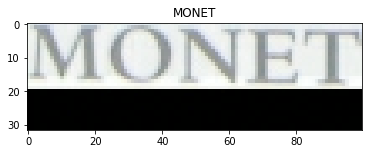

Ground truth:  STOP
image shape (32, 100, 3)
7


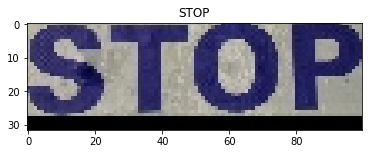

Ground truth:  First
image shape (32, 100, 3)
8


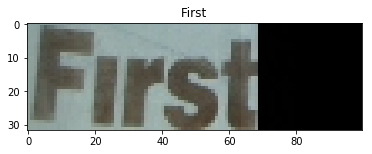

Ground truth:  prospects
image shape (32, 100, 3)
9


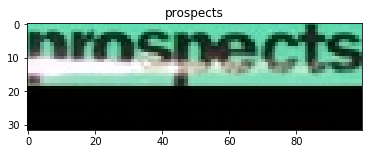

Ground truth:  Computer
image shape (32, 100, 3)
10


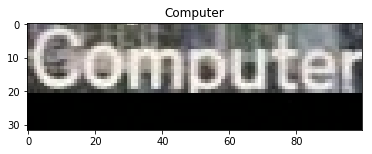

Ground truth:  FOR
image shape (32, 100, 3)
11


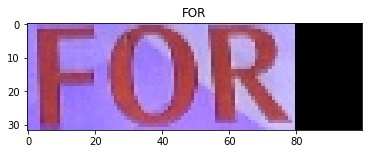

Ground truth:  of
image shape (32, 100, 3)
12


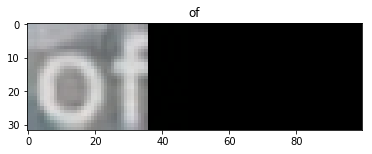

Ground truth:  PATH
image shape (32, 100, 3)
13


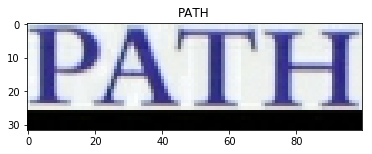

Ground truth:  please
image shape (32, 100, 3)
14


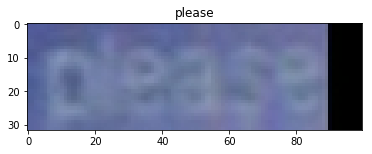

Ground truth:  SAFETY
image shape (32, 100, 3)
15


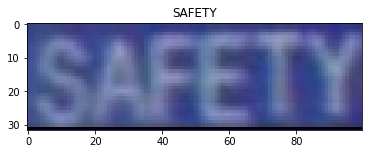

Ground truth:  in
image shape (32, 100, 3)
16


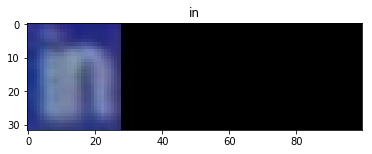

Ground truth:  lift
image shape (32, 100, 3)
17


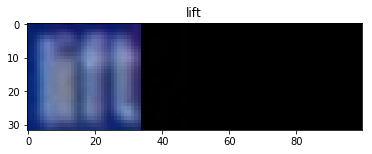

Ground truth:  BUILDING
image shape (32, 100, 3)
18


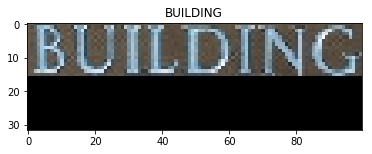

Ground truth:  press
image shape (32, 100, 3)
19


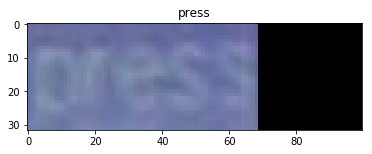

Ground truth:  Washing
image shape (32, 100, 3)
20


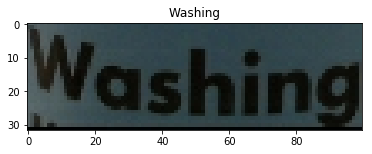

Ground truth:  GARDEN
image shape (32, 100, 3)
21


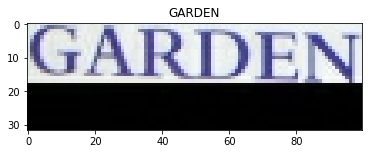

Ground truth:  CANCER
image shape (32, 100, 3)
22


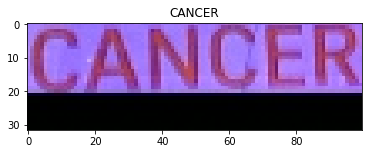

Ground truth:  ac
image shape (32, 100, 3)
23


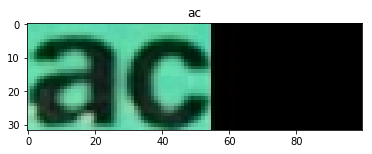

Ground truth:  MB
image shape (32, 100, 3)
24


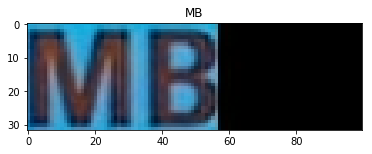

Ground truth:  LOAD
image shape (32, 100, 3)
25


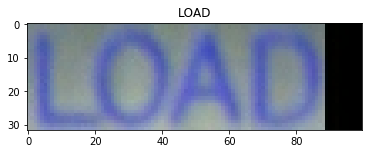

Ground truth:  DOOR
image shape (32, 100, 3)
26


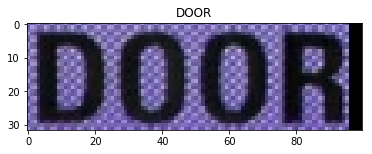

Ground truth:  Europe
image shape (32, 100, 3)
27


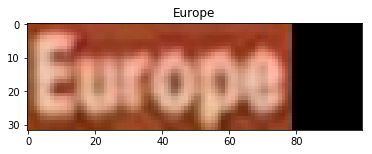

Ground truth:  if
image shape (32, 100, 3)
28


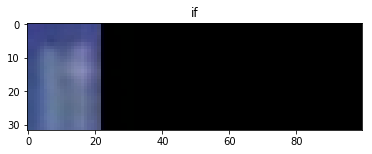

Ground truth:  National
image shape (32, 100, 3)
29


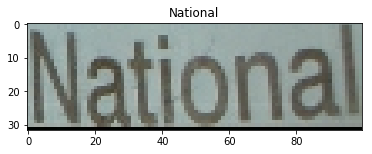

Ground truth:  top
image shape (32, 100, 3)
30


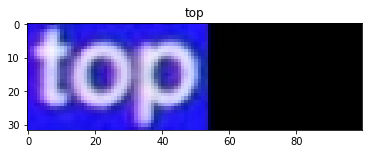

Ground truth:  COMPACT
image shape (32, 100, 3)
31


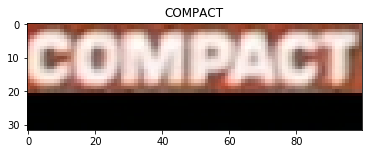

Ground truth:  PEPSI
image shape (32, 100, 3)
32


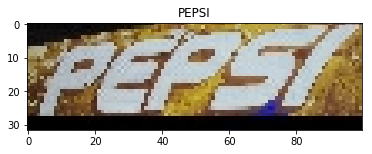

Ground truth:  arrive
image shape (32, 100, 3)
33


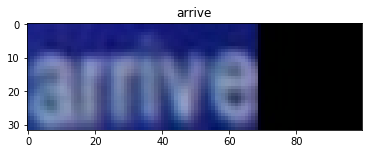

Ground truth:  alarm
image shape (32, 100, 3)
34


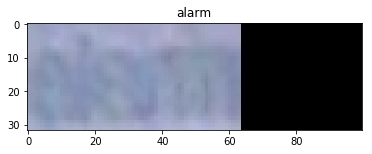

Ground truth:  Memorex
image shape (32, 100, 3)
35


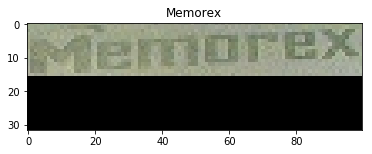

Ground truth:  LITTER
image shape (32, 100, 3)
36


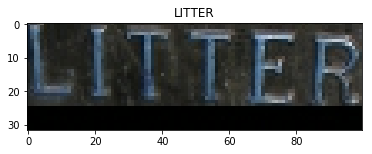

Ground truth:  Imported
image shape (32, 100, 3)
37


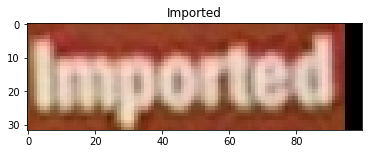

Ground truth:  Computer
image shape (32, 100, 3)
38


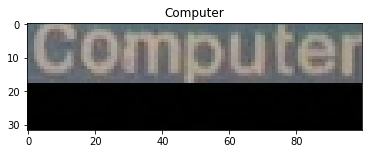

Ground truth:  without
image shape (32, 100, 3)
39


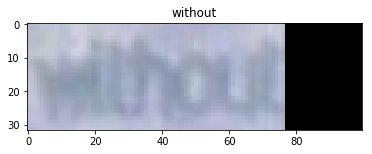

Ground truth:  DISC
image shape (32, 100, 3)
40


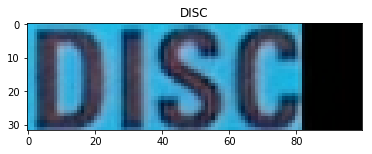

Ground truth:  EMERGENCY
image shape (32, 100, 3)
41


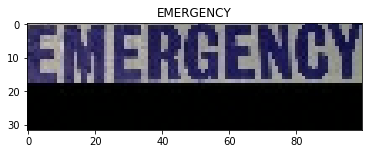

Ground truth:  www
image shape (32, 100, 3)
42


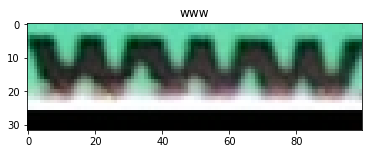

Ground truth:  INSPIRED
image shape (32, 100, 3)
43


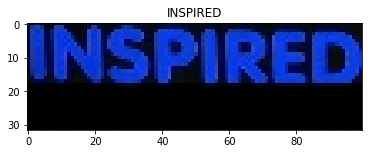

Ground truth:  by
image shape (32, 100, 3)
44


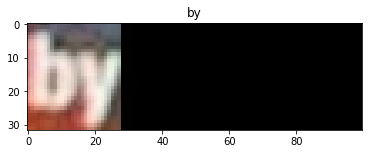

Ground truth:  delay
image shape (32, 100, 3)
45


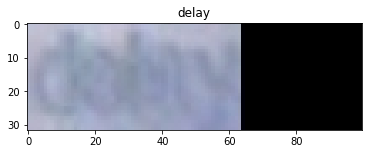

Ground truth:  at
image shape (32, 100, 3)
46


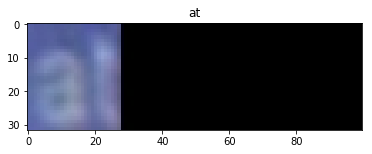

Ground truth:  EMERGENCY
image shape (32, 100, 3)
47


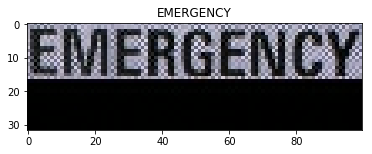

Ground truth:  JACOBSON
image shape (32, 100, 3)
48


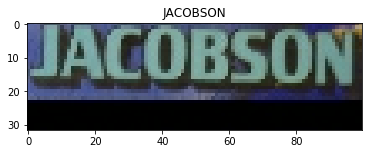

Ground truth:  AT
image shape (32, 100, 3)
49


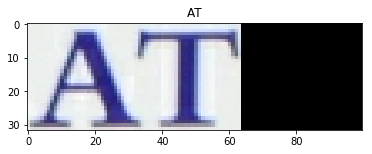

Ground truth:  Memorex
image shape (32, 100, 3)
50


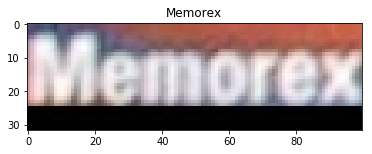

Ground truth:  NOT
image shape (32, 100, 3)
51


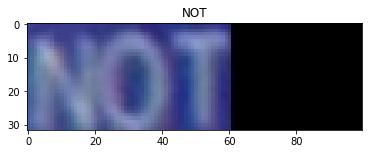

Ground truth:  Department
image shape (32, 100, 3)
52


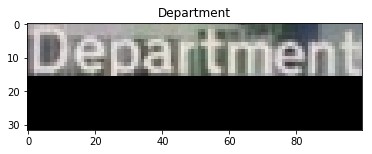

Ground truth:  PANIC
image shape (32, 100, 3)
53


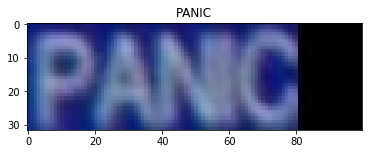

Ground truth:  at
image shape (32, 100, 3)
54


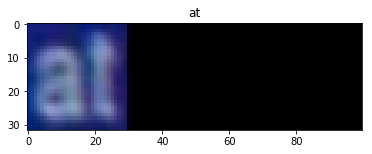

Ground truth:  RESEARCH
image shape (32, 100, 3)
55


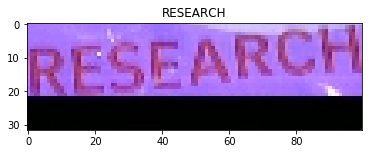

Ground truth:  you
image shape (32, 100, 3)
56


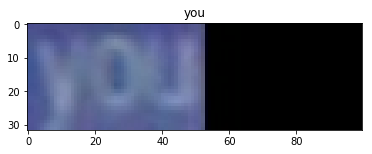

Ground truth:  BOROUGH
image shape (32, 100, 3)
57


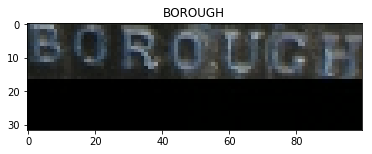

Ground truth:  PROTOTYPE
image shape (32, 100, 3)
58


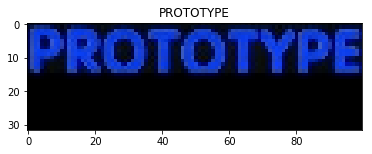

Ground truth:  Memorex
image shape (32, 100, 3)
59


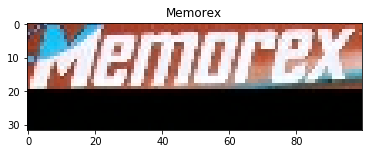

Ground truth:  liquid
image shape (32, 100, 3)
60


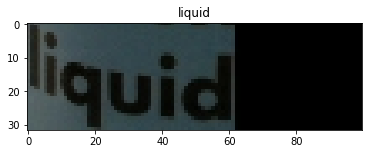

Ground truth:  sound
image shape (32, 100, 3)
61


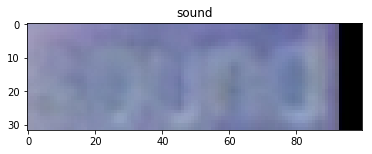

Ground truth:  REDBACK
image shape (32, 100, 3)
62


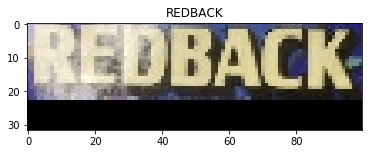

Ground truth:  PERSONS
image shape (32, 100, 3)
63


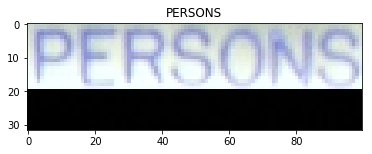

Ground truth:  HOWARD
image shape (32, 100, 3)
64


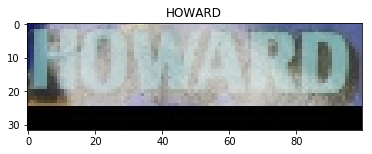

Ground truth:  regular
image shape (32, 100, 3)
65


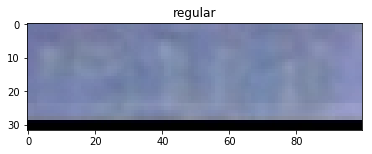

Ground truth:  the
image shape (32, 100, 3)
66


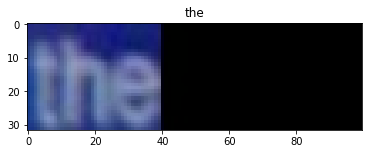

Ground truth:  Information
image shape (32, 100, 3)
67


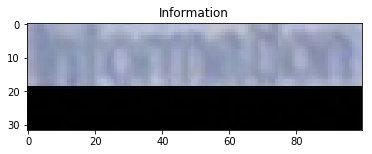

Ground truth:  desk
image shape (32, 100, 3)
68


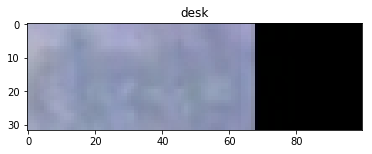

Ground truth:  Products
image shape (32, 100, 3)
69


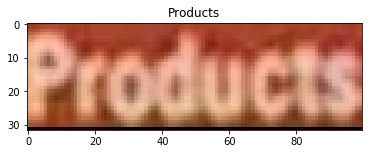

Ground truth:  R
image shape (32, 100, 3)
70


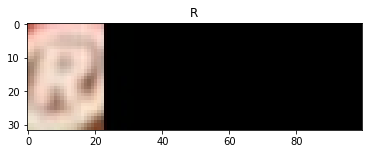

Ground truth:  WASHINGTON
image shape (32, 100, 3)
71


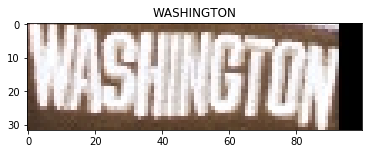

Ground truth:  Science
image shape (32, 100, 3)
72


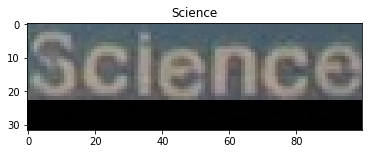

Ground truth:  UK
image shape (32, 100, 3)
73


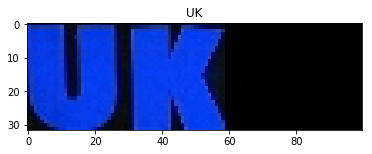

Ground truth:  COMPATIBILITY
image shape (32, 100, 3)
74


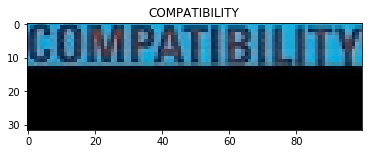

Ground truth:  up
image shape (32, 100, 3)
75


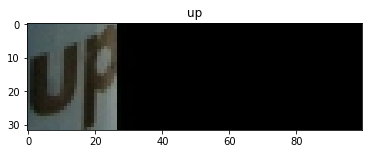

Ground truth:  Science
image shape (32, 100, 3)
76


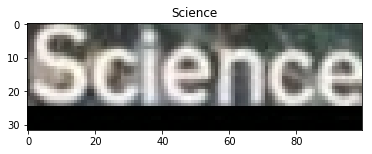

Ground truth:  uk
image shape (32, 100, 3)
77


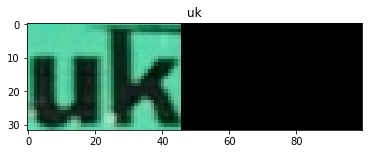

Ground truth:  alarm
image shape (32, 100, 3)
78


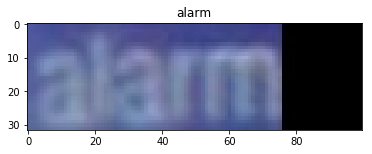

Ground truth:  become
image shape (32, 100, 3)
79


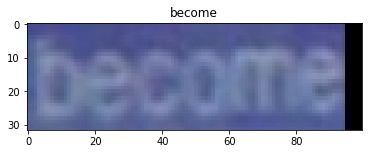

Ground truth:  Department
image shape (32, 100, 3)
80


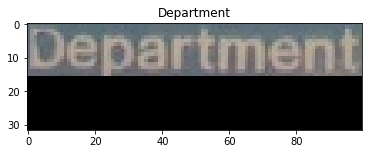

Ground truth:  thi
image shape (32, 100, 3)
81


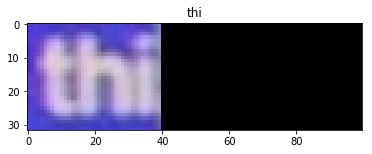

Ground truth:  UK
image shape (32, 100, 3)
82


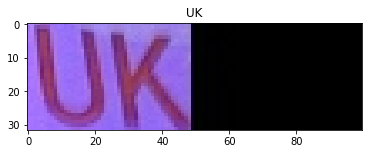

Ground truth:  PanaSync
image shape (32, 100, 3)
83


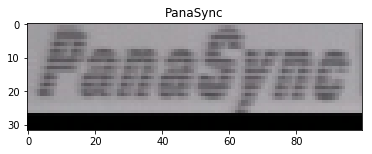

Ground truth:  help
image shape (32, 100, 3)
84


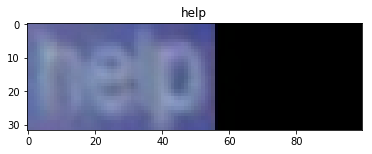

Ground truth:  UNIVERSAL
image shape (32, 100, 3)
85


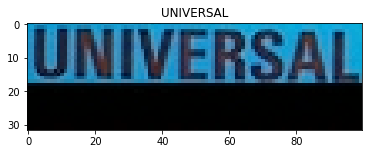

Ground truth:  NOTICE
image shape (32, 100, 3)
86


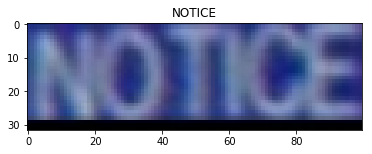

Ground truth:  CONTROL
image shape (32, 100, 3)
87


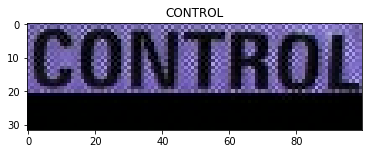

Ground truth:  the
image shape (32, 100, 3)
88


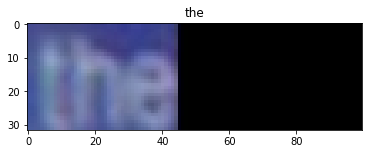

Ground truth:  LIFE
image shape (32, 100, 3)
89


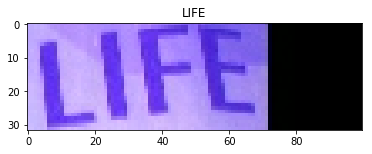

Ground truth:  RECORDABLE
image shape (32, 100, 3)
90


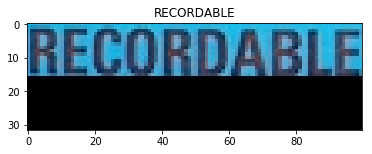

Ground truth:  second
image shape (32, 100, 3)
91


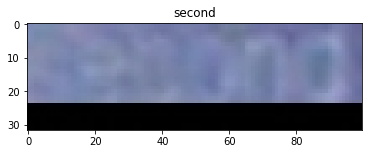

Ground truth:  will
image shape (32, 100, 3)
92


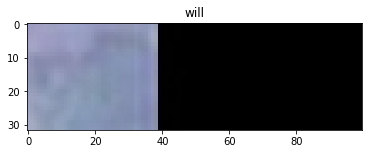

Ground truth:  trapped
image shape (32, 100, 3)
93


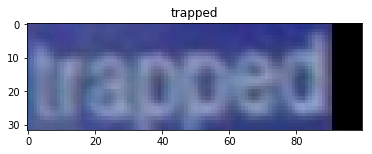

Ground truth:  RACE
image shape (32, 100, 3)
94


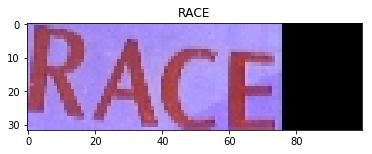

Ground truth:  smokin
image shape (32, 100, 3)
95


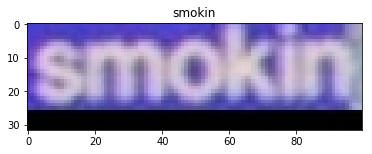

Ground truth:  No
image shape (32, 100, 3)
96


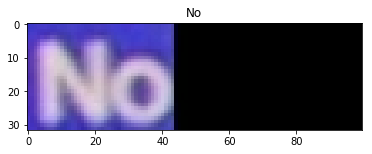

Ground truth:  TESCO
image shape (32, 100, 3)
97


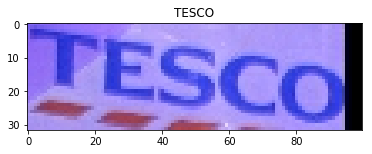

Ground truth:  powered
image shape (32, 100, 3)
98


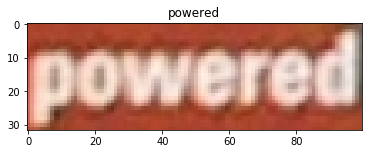

Ground truth:  RAB
image shape (32, 100, 3)
99


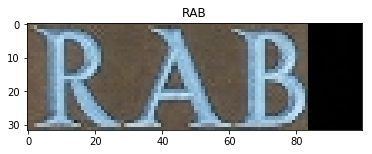

Ground truth:  OR
image shape (32, 100, 3)
100


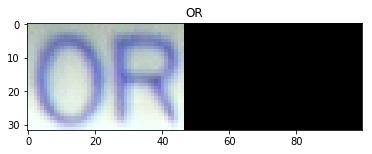

Ground truth:  PLEASE
image shape (32, 100, 3)
101


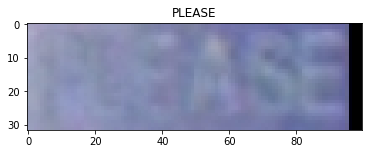

Ground truth:  intervals
image shape (32, 100, 3)
102


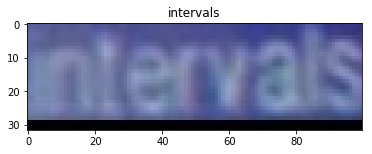

Ground truth:  The
image shape (32, 100, 3)
103


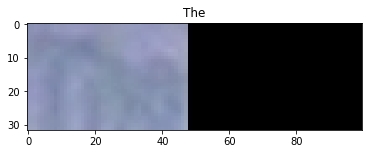

Ground truth:  will
image shape (32, 100, 3)
104


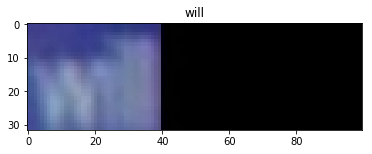

Ground truth:  the
image shape (32, 100, 3)
105


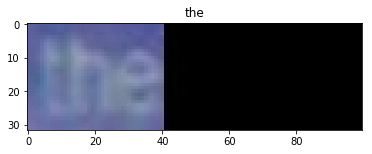

Ground truth:  and
image shape (32, 100, 3)
106


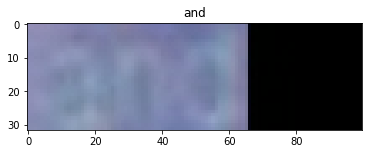

Ground truth:  Bus
image shape (32, 100, 3)
107


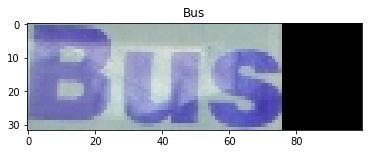

Ground truth:  postgrad
image shape (32, 100, 3)
108


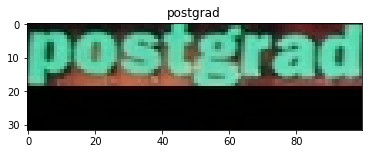

Ground truth:  RECORDS
image shape (32, 100, 3)
109


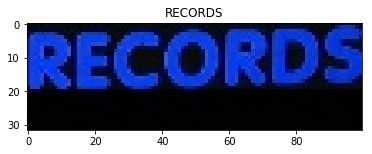

Ground truth:  Recordable
image shape (32, 100, 3)
110


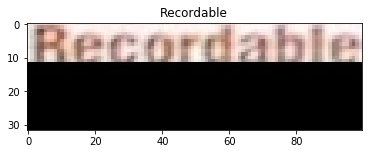

Ground truth:  BUTLER
image shape (32, 100, 3)
111


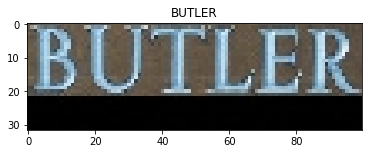

Ground truth:  VALUE
image shape (32, 100, 3)
112


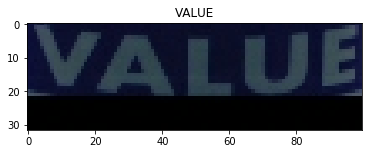

Ground truth:  PROFESSIONAL
image shape (32, 100, 3)
113


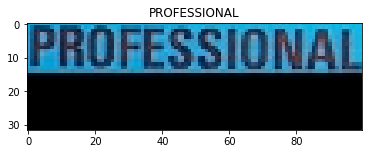

Ground truth:  CLAUDE
image shape (32, 100, 3)
114


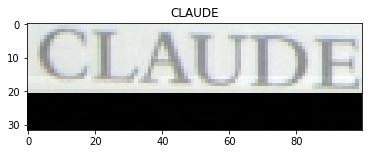

Ground truth:  of
image shape (32, 100, 3)
115


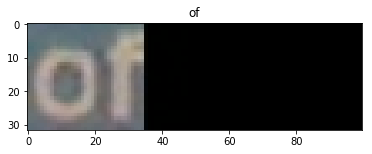

Ground truth:  point
image shape (32, 100, 3)
116


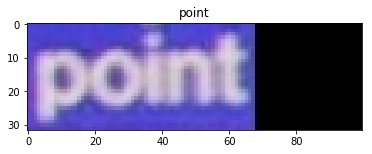

Ground truth:  conditions
image shape (32, 100, 3)
117


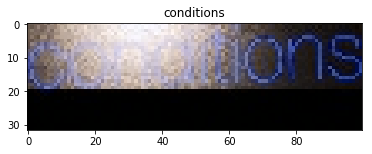

Ground truth:  COMPACT
image shape (32, 100, 3)
118


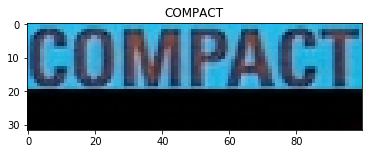

Ground truth:  DO
image shape (32, 100, 3)
119


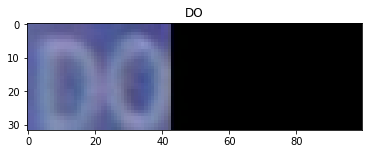

Ground truth:  DANCE
image shape (32, 100, 3)
120


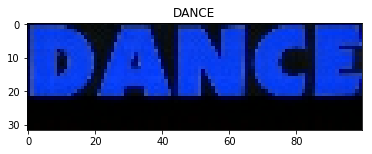

Ground truth:  Eastern
image shape (32, 100, 3)
121


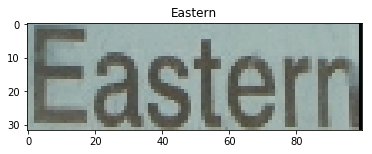

Ground truth:  f
image shape (32, 100, 3)
122


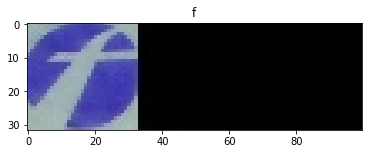

Ground truth:  study
image shape (32, 100, 3)
123


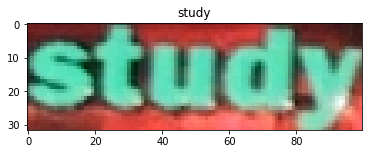

Ground truth:  TESCO
image shape (32, 100, 3)
124


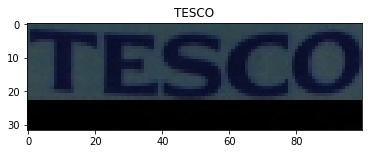

Ground truth:  Simon
image shape (32, 100, 3)
125


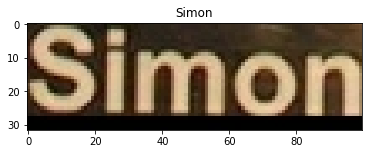

Ground truth:  COMPATIBLE
image shape (32, 100, 3)
126


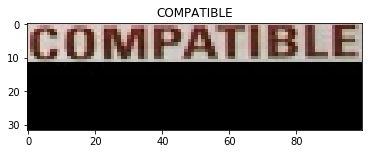

Ground truth:  Times
image shape (32, 100, 3)
127


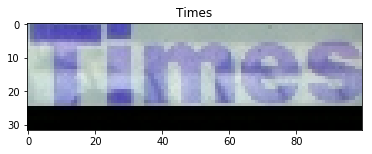

Ground truth:  Part
image shape (32, 100, 3)
128


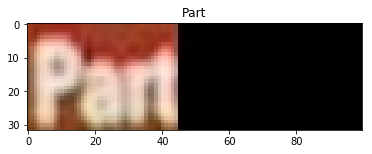

Ground truth:  THE
image shape (32, 100, 3)
129


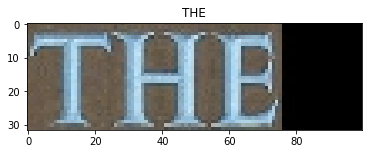

Ground truth:  disc
image shape (32, 100, 3)
130


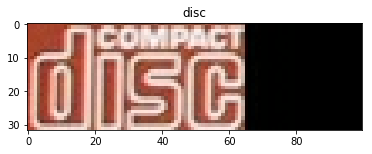

Ground truth:  Memorex
image shape (32, 100, 3)
131


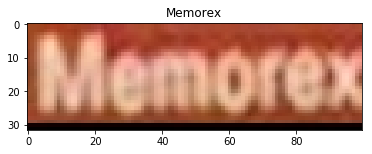

Ground truth:  MB
image shape (32, 100, 3)
132


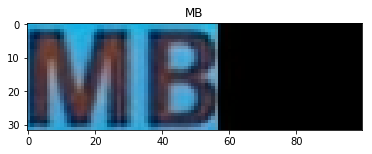

Ground truth:  No
image shape (32, 100, 3)
133


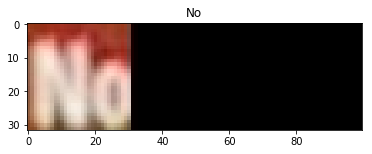

Ground truth:  beyond
image shape (32, 100, 3)
134


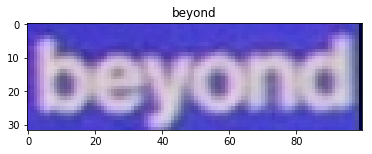

Ground truth:  GIVERNY
image shape (32, 100, 3)
135


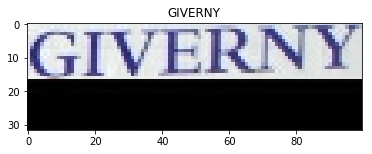

Ground truth:  european
image shape (32, 100, 3)
136


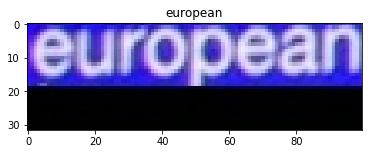

Ground truth:  KG
image shape (32, 100, 3)
137


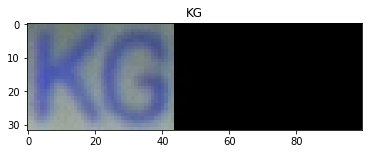

SystemExit: 

/home/dataj/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [12]:
tf.app.run(main)